# Stable Diffusion with Repeatable Seeds

This example shows how to use the Stable Diffusion pipeline to tweak generated images using repeatable seeds.

In [1]:
import torch
from diffusers import StableDiffusionPipeline

device = "cuda"
model_id = "CompVis/stable-diffusion-v1-4"

pipe = StableDiffusionPipeline.from_pretrained(
    model_id,
    use_auth_token=True
).to(device)

We'll initially perform a prediction of a few images to see which one we like the most. In order to view them nicely, we'll first create a helper function to present results in a grid. This was taken from the 🤗 Hugging Face [Stable Diffusion blog post](https://huggingface.co/blog/stable_diffusion).

In [2]:
from PIL import Image

def image_grid(imgs, rows, cols):
    assert len(imgs) == rows*cols

    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size
    
    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid


In this example we are going to generate 6 images at once. Feel free to update it depending on how much RAM your GPU has.

In [3]:
num_images = 6

In order to reuse the seeds we need to generate the latents ourselves. Otherwise, the pipeline will do it internally and we won't have a way to replicate them.

Latents are the initial random Gaussian noise that gets transformed to actual images during the diffusion process.

To generate them, we'll use a different random seed for each latent.

In [4]:
generator = torch.Generator(device=device)

width = 512
height = 512

latents = None
seeds = []
for _ in range(num_images):
    # Get a new random seed, store it and use it as the generator state
    seed = generator.seed()
    seeds.append(seed)
    generator = generator.manual_seed(seed)
    
    image_latents = torch.randn(
        (1, pipe.unet.in_channels, height // 8, width // 8),
        generator = generator,
        device = device
    )
    latents = image_latents if latents is None else torch.cat((latents, image_latents))
    
# latents should have shape (6, 4, 64, 64) in this case
latents.shape

torch.Size([6, 4, 64, 64])

We are now ready to generate the images. We'll send the pipeline the latents we want to use.

In [5]:
prompt = "Labrador in the style of Vermeer"

with torch.autocast("cuda"):
    images = pipe(
        [prompt] * num_images,
        guidance_scale=7.5,
        latents = latents,
    )["sample"]

0it [00:00, ?it/s]

Cool, let's display them.

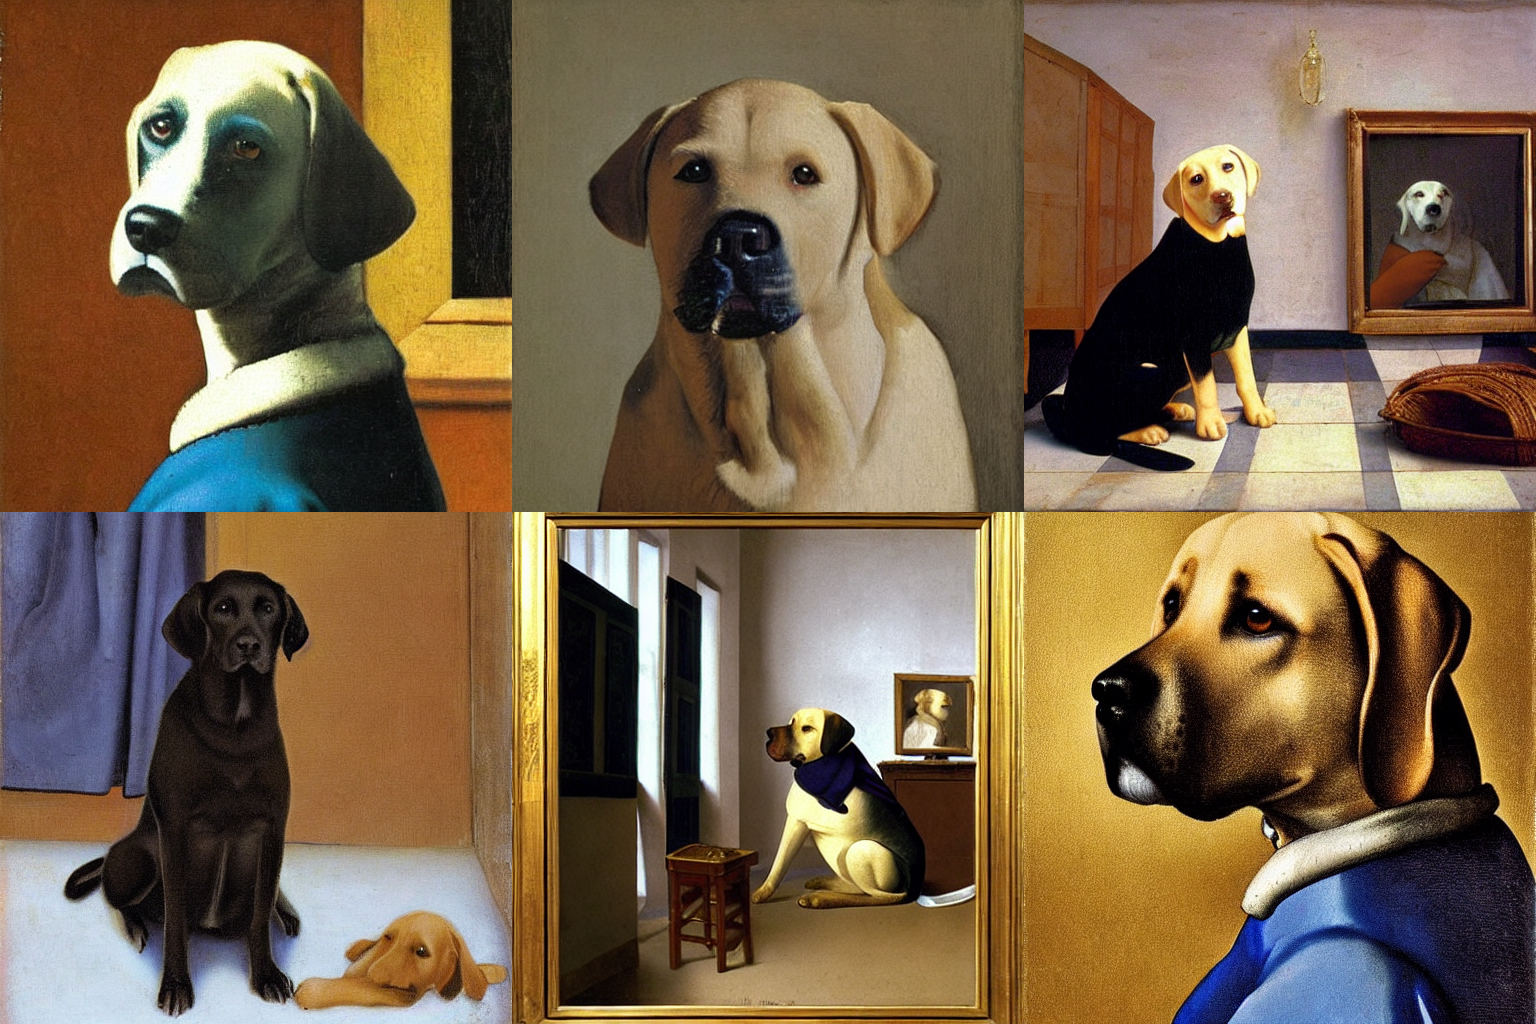

In [6]:
image_grid(images, 2, 3)

I like the sixth one! If we use the same seed we used before to regenerate those latents, we should have the same result.

In [7]:
seed = seeds[5]   # Sixth one
seed

3788595447813497

In [8]:
generator.manual_seed(seed)

latents = torch.randn(
    (1, pipe.unet.in_channels, height // 8, width // 8),
    generator = generator,
    device = device
)

We could just have reused `latents[5]` instead. But just taking note of the seeds will be enough te replicate the generation any time we like.

If we repeat the generation (of a single image) with these latents, we should get the same image as before:

0it [00:00, ?it/s]

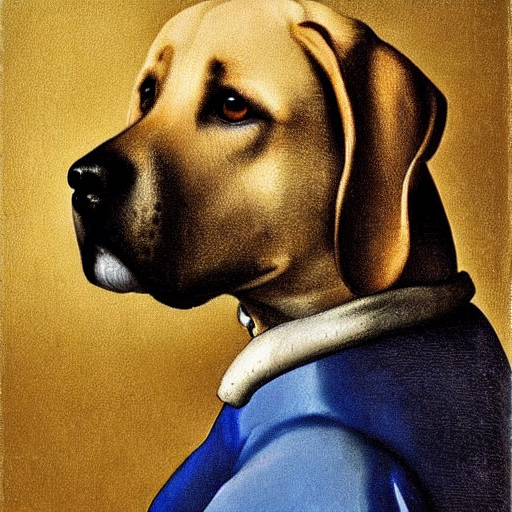

In [9]:
with torch.autocast("cuda"):
    image = pipe(
        [prompt] * 1,
        guidance_scale=7.5,
        latents = latents,
    )["sample"]
    
image[0]

It worked!

We can now try to tweak the prompt _keeping the same latents_. This should create an image with a similar structure but different content or style.

For example:

0it [00:00, ?it/s]

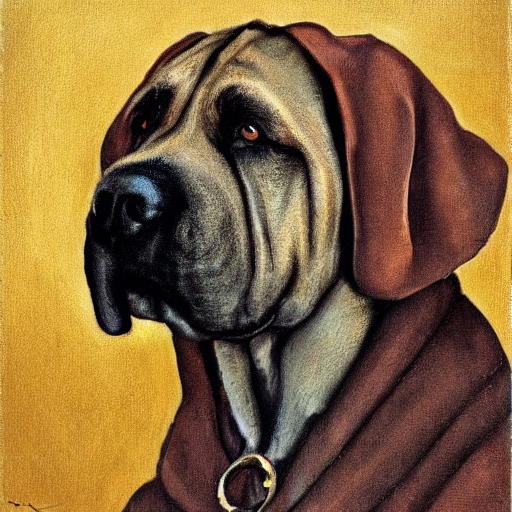

In [10]:
prompt = "Mastiff in the style of Vermeer"

with torch.autocast("cuda"):
    image = pipe(
        [prompt] * 1,
        guidance_scale=7.5,
        latents = latents,
    )["sample"]
    
image[0]